In [1]:
# project 2, Group 7

In [2]:
# task 1

In [2]:
class OptimizationProblem:
    def __init__(self, f, grad=None):
        self.f = f
        self.grad = grad

    def evaluate(self, x):
        return float(self.f(x))

    def gradient(self, x):
        if self.grad is None:
            raise NotImplementedError("No gradient provided.")
        return np.array(self.grad(x), dtype=float)

In [4]:
# task 2: general opitimization class

In [3]:
class OptimizationMethod:
    def __init__(self, problem, tol=1e-6, max_iter=100):
        self.problem = problem
        self.tol = tol
        self.max_iter = max_iter
        self.history = []

    def compute_direction(self, x):
        # need implemention
        raise NotImplementedError

    def line_search(self, x, s, g):
        alpha = 1.0  # will be changed in the subsequet tasks 
        return alpha

    def solve(self, x0):
        x = np.array(x0, dtype=float)
        self.history.append(x.copy()) # record the history for task5
        for _ in range(self.max_iter):
            g = self.problem.gradient(x)
            if np.linalg.norm(g) < self.tol:
                break
            s = self.compute_direction(x, g)
            alpha = self.line_search(x, s, g)
            x = x + alpha * s
            self.history.append(x.copy()) # record the history for task5
        return x


使用newton method来测试[task1，task2]，可以参考

In [4]:
import numpy as np
from chebyquad_problem import chebyquad, gradchebyquad

#newton method
def fd_hessian(f, x, eps=1e-6):
    n = x.size
    H = np.zeros((n, n))
    fx = f(x)
    for i in range(n):
        ei = np.zeros(n); ei[i] = 1.0
        for j in range(i, n):
            ej = np.zeros(n); ej[j] = 1.0
            if i == j:
                H[i, i] = (f(x+eps*ei) - 2*fx + f(x-eps*ei)) / (eps**2)
            else:
                fpp = f(x + eps*ei + eps*ej)
                fpm = f(x + eps*ei - eps*ej)
                fmp = f(x - eps*ei + eps*ej)
                fmm = f(x - eps*ei - eps*ej)
                H[i, j] = H[j, i] = (fpp - fpm - fmp + fmm) / (4*eps**2)
    # 对称化（Task3 要求 G := 0.5*(G + G^T)）
    return 0.5*(H + H.T)

class NewtonMethod(OptimizationMethod):
    def compute_direction(self, x, g):
        H = fd_hessian(self.problem.evaluate, x)
        # 解 H s = -g
        return -np.linalg.solve(H, g)

    # 可选：以后你可以在 Task4 替换为 exact line search
    # def line_search(self, x, s, g): ...
for n in (4, 8, 11):
    x0 = np.linspace(0, 1, n)  # 题目里常用的初始点
    prob = OptimizationProblem(chebyquad, gradchebyquad)
    x_star = NewtonMethod(prob, tol=1e-8, max_iter=200).solve(x0)
    print(f"n={n}, x*=", np.round(x_star, 6), " f(x*)=", prob.evaluate(x_star))

n=4, x*= [0.112702 0.3709   0.6291   0.887298]  f(x*)= 4.6992690643048555e-32
n=8, x*= [0.051472 0.199429 0.308722 0.427708 0.572292 0.691278 0.800571 0.948528]  f(x*)= 1.230471919335472e-18
n=11, x*= [0.011956 0.011956 0.011956 0.011956 0.246671 0.40629  0.661196 0.983707
 0.983707 0.851175 0.888936]  f(x*)= 0.7228032041299932


In [5]:
#task 3
import numpy as np

def fd_hessian(f, x, eps=1e-6):
    n = x.size
    H = np.zeros((n, n))
    fx = f(x)
    for i in range(n):
        ei = np.zeros(n); ei[i] = 1.0
        for j in range(i, n):
            ej = np.zeros(n); ej[j] = 1.0
            if i == j:
                H[i, i] = (f(x + eps * ei) - 2 * fx + f(x - eps * ei)) / eps**2
            else:
                fpp = f(x + eps * ei + eps * ej)
                fpm = f(x + eps * ei - eps * ej)
                fmp = f(x - eps * ei + eps * ej)
                fmm = f(x - eps * ei - eps * ej)
                H[i, j] = H[j, i] = (fpp - fpm - fmp + fmm) / (4 * eps**2)
    return 0.5 * (H + H.T)

class NewtonMethod(OptimizationMethod):
    def compute_direction(self, x, g):
        H = fd_hessian(self.problem.evaluate, x)
        return -np.linalg.solve(H, g)

In [6]:
# task 4
from scipy.optimize import minimize_scalar

class NewtonMethodExactLineSearch(OptimizationMethod):
    def compute_direction(self, x, g):
        H = fd_hessian(self.problem.evaluate, x)
        return -np.linalg.solve(H, g)

    def line_search(self, x, s, g):
        phi = lambda alpha: self.problem.evaluate(x + alpha * s)
        res = minimize_scalar(phi, bounds=(0, 1), method='bounded')
        return res.x

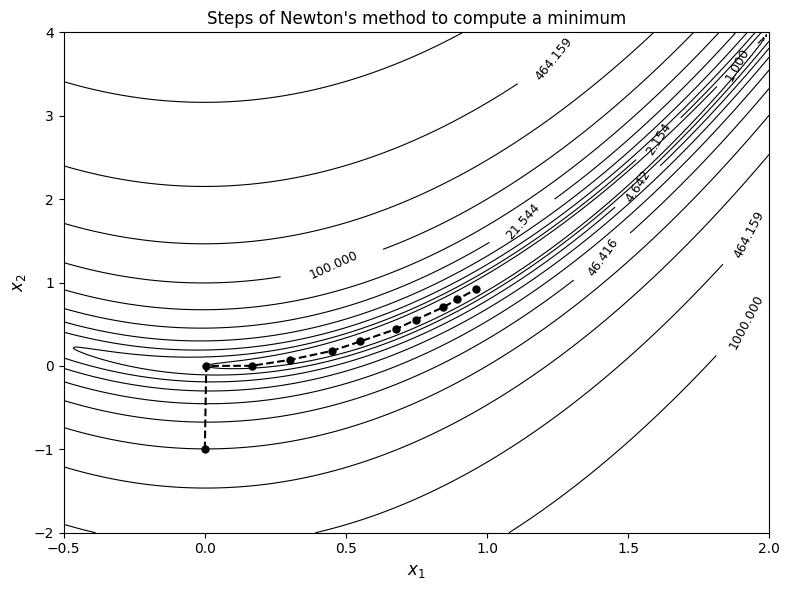

In [7]:
#task 5
import matplotlib.pyplot as plt
import numpy as np

# Define Rosenbrock function and its gradient
def rosenbrock_f(x):
    return 100 * (x[1] - x[0]**2)**2 + (1 - x[0])**2

def rosenbrock_grad(x):
    df_dx0 = -400 * x[0] * (x[1] - x[0]**2) - 2 * (1 - x[0])
    df_dx1 = 200 * (x[1] - x[0]**2)
    return np.array([df_dx0, df_dx1])

problem = OptimizationProblem(f=rosenbrock_f, grad=rosenbrock_grad)
optimizer = NewtonMethodExactLineSearch(problem, max_iter=10)
x0 = np.array([0.0, -1.0])
xmin = optimizer.solve(x0)
trajectory = np.vstack(optimizer.history)

x_vals = np.linspace(-2, 2, 400)
y_vals = np.linspace(-2, 4, 400)
X, Y = np.meshgrid(x_vals, y_vals)
Z = 100 * (Y - X**2)**2 + (1 - X)**2

plt.figure(figsize=(8, 6))

levels = np.logspace(0, 3, 10) # 从1到1000的对数分布
CS = plt.contour(X, Y, Z, levels=levels, colors='black', linewidths=0.8)
plt.clabel(CS, inline=True, fontsize=9, fmt="%.3f")


plt.plot(trajectory[:, 0], trajectory[:, 1], 'k--', linewidth=1.5)
plt.plot(trajectory[:, 0], trajectory[:, 1], 'ko', markersize=5)

plt.xlabel('$x_1$', fontsize=12)
plt.ylabel('$x_2$', fontsize=12)
plt.title("Steps of Newton's method to compute a minimum", fontsize=12)
plt.xlim([-0.5, 2.0])
plt.ylim([-2.0, 4.0])
plt.grid(False)
plt.tight_layout()
plt.show()


In [ ]:
# Task 6 
def line_search_wolfe(problem, x, p, grad_x, c1=1e-4, c2=0.9, alpha0=1.0, alpha_max=64.0, max_iter=50):
    phi0 = problem.evaluate(x)
    dphi0 = float(np.dot(grad_x, p))

    # 如果方向不是下降方向，修正为负梯度
    if dphi0 >= 0:
        p = -grad_x
        dphi0 = -float(np.dot(grad_x, grad_x))

    def phi(a):  # 一维函数
        return problem.evaluate(x + a * p)

    def dphi(a):  # 一维导数
        return float(np.dot(problem.gradient(x + a * p), p))

    # Bracketing 阶段
    alpha_prev = 0.0
    phi_prev = phi0
    alpha = float(alpha0)

    for _ in range(max_iter):
        phi_a = phi(alpha)
        if (phi_a > phi0 + c1 * alpha * dphi0) or (_ > 0 and phi_a >= phi_prev):
            alo, ahi = alpha_prev, alpha
            break
        dphi_a = dphi(alpha)
        if abs(dphi_a) <= -c2 * dphi0:  # Wolfe 条件满足
            return alpha
        if dphi_a >= 0:
            alo, ahi = alpha, alpha_prev
            break
        alpha_prev, phi_prev = alpha, phi_a
        alpha = min(alpha * 2.0, alpha_max) # 我认为这里的公式不对，按照书上的定义，你应该使用τ1，τ2，τ3. By wtc
    else:
        return alpha  # 未找到 bracket，直接返回

    # Zoom 阶段
    phi_alo = phi(alo)
    for _ in range(max_iter):
        aj = 0.5 * (alo + ahi)
        phi_aj = phi(aj)
        if (phi_aj > phi0 + c1 * aj * dphi0) or (phi_aj >= phi_alo):
            ahi = aj
        else:
            dphi_aj = dphi(aj)
            if abs(dphi_aj) <= -c2 * dphi0:
                return aj
            if dphi_aj * (ahi - alo) >= 0:
                ahi = alo
            alo = aj
            phi_alo = phi_aj
    return aj  # 返回最后一个候选


![task6](formula_task6.png)

In [9]:
# Task 7
x0 = np.array([-1.2, 1.0])              # 初始点
g0 = problem.gradient(x0)
p0 = -g0                                # 用负梯度方向
rho = 0.01
sigma = 0.1

alpha = line_search_wolfe(problem, x0, p0, g0, c1=rho, c2=sigma)

x1 = x0 + alpha * p0
f0 = problem.evaluate(x0)
f1 = problem.evaluate(x1)

print(f"alpha = {alpha:.6f}")
print(f"f(x0) = {f0:.6f}, f(x1) = {f1:.6f}")

# 检查 Wolfe–Powell 条件
armijo_ok = (f1 <= f0 + rho * alpha * np.dot(g0, p0))
curvature_ok = (np.dot(problem.gradient(x1), p0) >= sigma * np.dot(g0, p0))

print(f"Armijo condition (ρ={rho}) satisfied: {armijo_ok}")
print(f"Wolfe curvature condition (σ={sigma}) satisfied: {curvature_ok}")


alpha = 0.000732
f(x0) = 24.200000, f(x1) = 4.216348
Armijo condition (ρ=0.01) satisfied: True
Wolfe curvature condition (σ=0.1) satisfied: True


In [10]:
# Task 8 
class NewtonMethodInexactLineSearch(OptimizationMethod):
    def compute_direction(self, x, g):
        H = fd_hessian(self.problem.evaluate, x)   # 有限差分 Hessian
        return -np.linalg.solve(H, g)

    def line_search(self, x, s, g):
        rho = 0.01
        sigma = 0.1
        return line_search_wolfe(self.problem, x, s, g, c1=rho, c2=sigma)


In [ ]:
# Task 9

class QuasiNewtonMethod(OptimizationMethod):
    def __init__(self, problem, tol=1e-6, max_iter=100):
        super().__init__(problem, tol, max_iter)

    def solve(self, x0):
        x = np.array(x0, dtype=float)
        g = self.problem.gradient(x)
        n = len(x)

        # Start with identity as inverse Hessian approx
        H = np.eye(n)

        self.history.append(x.copy())

        for _ in range(self.max_iter):
            # Convergence check
            if np.linalg.norm(g) < self.tol:
                break

            # Search direction
            s = -H.dot(g)

            # Inexact line search (Wolfe)
            alpha = line_search_wolfe(self.problem, x, s, g)
            x_new = x + alpha * s
            g_new = self.problem.gradient(x_new)

            # Update matrices
            y = g_new - g
            s = x_new - x
            H = self.update(H, s, y, g, g_new)

            # Move to next iterate
            x, g = x_new, g_new
            self.history.append(x.copy())

        return x

    def update(self, H, s, y, g, g_new):
        raise NotImplementedError


In [12]:
# Task 9.1 good Broyden
class GoodBroyden(QuasiNewtonMethod):
    def update(self, H, s, y, g, g_new):
        # Compute G = H^{-1} implicitly by Sherman-Morrison
        Hy = H.dot(y)
        u = s - Hy
        denom = u @ y
        if abs(denom) < 1e-12:
            return H
        # Sherman–Morrison
        H_new = H + np.outer(u, u) / denom
        return H_new


In [13]:
# Task 9.2 Bad Broyden
class BadBroyden(QuasiNewtonMethod):
    def update(self, H, s, y, g, g_new):
        u = s - H.dot(y)
        denom = u @ y
        if abs(denom) < 1e-12:
            return H
        H_new = H + np.outer(u, u) / denom
        return H_new


In [14]:
# Task 9.3 Symmetric Broyden
class SymmetricBroyden(QuasiNewtonMethod):
    def update(self, H, s, y, g, g_new):
        u = s - H.dot(y)
        denom = u @ y
        if abs(denom) < 1e-12:
            return H
        upd = np.outer(u, u) / denom
        H_new = H + 0.5 * (upd + upd.T)   # symmetrize
        return H_new


In [15]:
# Task 9.4 DFP
class DFP(QuasiNewtonMethod):
    def update(self, H, s, y, g, g_new):
        sy = s @ y
        if abs(sy) < 1e-12:
            return H
        Hy = H.dot(y)
        H_new = H + np.outer(s, s) / sy - np.outer(Hy, Hy) / (y @ Hy)
        return H_new



In [16]:
# Task 9.5 BFGS
class BFGS(QuasiNewtonMethod):
    def update(self, H, s, y, g, g_new):
        rho = 1.0 / (y @ s)
        I = np.eye(len(s))
        V = I - rho * np.outer(s, y)
        H_new = V @ H @ V.T + rho * np.outer(s, s)
        return H_new


In [17]:
# Task 9 
# Example usage
problem = OptimizationProblem(f=rosenbrock_f, grad=rosenbrock_grad)
x0 = np.array([-1.2, 1.0])

optimizer = BFGS(problem, max_iter=50)
xmin = optimizer.solve(x0)

print("Found minimum:", xmin)


Found minimum: [1. 1.]
